In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)

import datasets
import losses
import cnns
import model

In [2]:
get_cnns = cnns.ResNet50
dataset = datasets.MEBeauty(get_cnns()[0])

In [3]:
base_options = python.BaseOptions(model_asset_path="blaze_face_short_range.tflite")
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

In [4]:
"""
preprocess image using mediapipe
"""
def preprocess(path):
    image = mp.Image.create_from_file(path)
    image_copy = np.copy(image.numpy_view())
    detection_result = detector.detect(image)
    detection = detection_result.detections[0]

    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height

    cropped_image = image_copy[bbox.origin_y:bbox.origin_y + bbox.height,
                            bbox.origin_x:bbox.origin_x + bbox.width]

    rgb_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    new_path = path.replace(".jpg","_")+"cropped.jpg"
    cv2.imwrite(new_path, rgb_image)

    image = img_to_array(load_img(
        new_path,
        target_size=(224,224),
        interpolation="bicubic"
    ))

    image = image[...,::-1]
    #image = image - dataset.mean

    return image

In [30]:
"""
Set ensemble to False to run a single model
Specify the model with model_type
The types are "resnet50", "senet50", "vgg16"
"""
def predict(image, model_type="resnet50", ensemble=True):
    p = np.zeros(10)
    if ensemble:
        for get_cnns in [cnns.ResNet50, cnns.VGG16, cnns.SENet50]:
            dataset = datasets.MEBeauty(get_cnns()[0])
            m = model.Model(get_cnns, dataset)
            m.construct(supress=True)
            m.compile("cce")
            for i in range(2):
                m.model.load_weights(m.pred_path+f"weights_{i}.hdf5")
                p += m.model.predict(get_cnns()[0].predict(np.array([image])))[0] 
        p /= 6
        return p
    
    if model_type == "resnet50": get_cnns = cnns.ResNet50
    elif model_type == "senet50": get_cnns = cnns.SENet50
    else: get_cnns = cnns.VGG16
    
    dataset = datasets.MEBeauty(get_cnns()[0])
    m = model.Model(get_cnns, dataset)
    m.construct(supress=True)
    m.compile("cce")

    m.model.load_weights(m.pred_path+"weights_0.hdf5")
    return m.model.predict(get_cnns()[0].predict(np.array([image])))[0] 

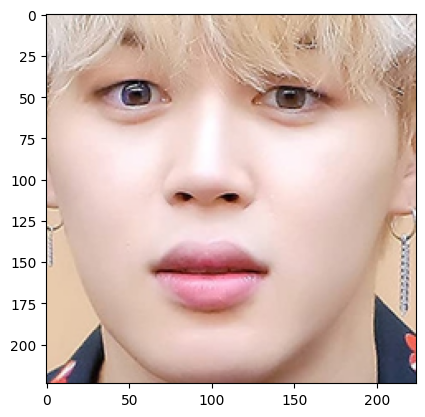

In [27]:
image = preprocess("./test.jpg")
plt.imshow(image[...,::-1]/255)

1/1 [==============================] - 0s 16ms/step


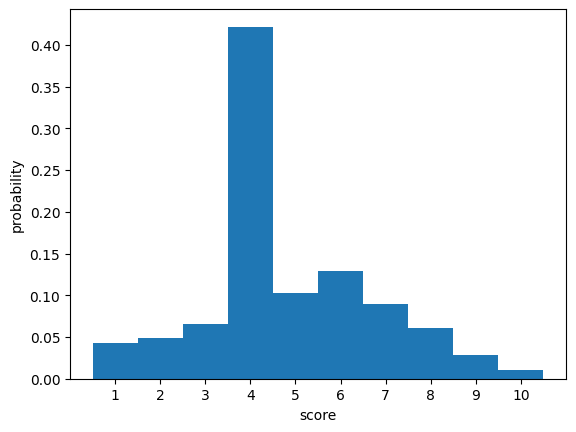

In [33]:
p = predict(image)
scores = np.array([i+1 for i in range(10)])
plt.xticks(scores)
plt.bar(scores, p, width=1.0)
plt.xlabel("score")
plt.ylabel("probability")
plt.show()

In [34]:
mu = np.dot(p, scores)
sigma = np.sqrt(np.dot(p, scores**2) - mu**2)
print(f"Score: {mu}+-{sigma}")

Score: 4.786733215937692+-1.8714018811061197
